In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

import warnings

warnings.filterwarnings('ignore')

In [62]:
input_dir = r'C:\Users\Shin\Desktop\risk_factors_cervical_cancer.csv'
risk_factor_df = pd.read_csv(input_dir)
risk_factor_df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [63]:
risk_factor_df.info()
#이를 통해 결측치는 없는 것처럼 보인다.
#하지만 실제로 파일 안에서는 ?로 표시되어있는 것을 확인할 수 있다.
#대부분의 항목이 object형태로 되어있는 것을 확인할 수 있음. 
#우린 이 object형태를 float형태로 바꿔줘야함

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

In [64]:
def print_unique_values_df(df: pd.DataFrame):
    for col in list(df):
        print(f"Unique Values for '{col}': {df[col].unique()}")
        print(f"dtype for {col} is: {df[col].dtypes}")
        print("-" * 150)


print_unique_values_df(risk_factor_df)

#이를 통해 실제로 각 변수의 값들이 전부 숫자인 것을 확인할 수 있다. 또한 결측치는 전부 ?로만 채워져 있는 것도 확인가능.

Unique Values for 'Age': [18 15 34 52 46 42 51 26 45 44 27 43 40 41 39 37 38 36 35 33 31 32 30 23
 28 29 20 25 21 24 22 48 19 17 16 14 59 79 84 47 13 70 50 49]
dtype for Age is: int64
------------------------------------------------------------------------------------------------------------------------------------------------------
Unique Values for 'Number of sexual partners': ['4.0' '1.0' '5.0' '3.0' '2.0' '6.0' '?' '7.0' '15.0' '8.0' '10.0' '28.0'
 '9.0']
dtype for Number of sexual partners is: object
------------------------------------------------------------------------------------------------------------------------------------------------------
Unique Values for 'First sexual intercourse': ['15.0' '14.0' '?' '16.0' '21.0' '23.0' '17.0' '26.0' '20.0' '25.0' '18.0'
 '27.0' '19.0' '24.0' '32.0' '13.0' '29.0' '11.0' '12.0' '22.0' '28.0'
 '10.0']
dtype for First sexual intercourse is: object
-------------------------------------------------------------------------------------------

In [65]:
#object 형태로 되어있는 열 들을 float형태로 다 바꿔줘야한다.
cols_to_convert = ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
                   'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives',
                   'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)',
                   'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
                   'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                   'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV', 'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis']

for i in cols_to_convert:
    #위 열들을 전부 숫자로 변환, ?같이 숫자로 변환이 안되는 경우는 NaN으로 표기됨(errors='coerce')
    risk_factor_df[cols_to_convert] = risk_factor_df[cols_to_convert].apply(pd.to_numeric, errors="coerce")
    # 각 열의 결측치를 열 별 중앙값으로 채워넣음
    risk_factor_df[cols_to_convert] = risk_factor_df[cols_to_convert].fillna(risk_factor_df[cols_to_convert].median())


In [67]:
#age_cat이라는 새로운 입력변수를 만들고 나이별로 분류한 것을 추가시켰음

def age_cat(age):
    if age < 12:
        return "Child"
    elif age < 20:
        return "Teen"
    elif age < 30:
        return "20's"
    elif age < 40:
        return "30's"
    elif age < 50:
        return "40's"
    elif age < 60:
        return "50's"
    elif age < 70:
        return "60's"
    else:
        return "70+"


risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

In [68]:
#모든 성병 입력변수들의 값을 행별로 더해서 총 성병개수를 입력변수로하는 열을 새로 만들어줌
std_cols = {'STDs:condylomatosis',
            'STDs:cervical condylomatosis',
            'STDs:vaginal condylomatosis',
            'STDs:vulvo-perineal condylomatosis',
            'STDs:syphilis',
            'STDs:pelvic inflammatory disease',
            'STDs:genital herpes',
            'STDs:molluscum contagiosum',
            'STDs:AIDS',
            'STDs:HIV',
            'STDs:Hepatitis B',
            'STDs:HPV'}

risk_factor_df["total_std"] = risk_factor_df[list(std_cols)].sum(axis=1)
std_agg = risk_factor_df.groupby("age_cat", as_index=False)[list(std_cols)].sum()

In [69]:
# 자궁경부암 테스트 방법 4가지 입력변수를 모두 합쳐서 총합을 입력변수로 하는 새로운 열로 만들어줌
test_cols = ["Hinselmann", "Schiller", "Citology", "Biopsy"]
risk_factor_df["total_tests"] = risk_factor_df[test_cols].sum(axis = 1)

In [70]:
risk_factor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           858 non-null    float64
 2   First sexual intercourse            858 non-null    float64
 3   Num of pregnancies                  858 non-null    float64
 4   Smokes                              858 non-null    float64
 5   Smokes (years)                      858 non-null    float64
 6   Smokes (packs/year)                 858 non-null    float64
 7   Hormonal Contraceptives             858 non-null    float64
 8   Hormonal Contraceptives (years)     858 non-null    float64
 9   IUD                                 858 non-null    float64
 10  IUD (years)                         858 non-null    float64
 11  STDs                                858 non-n

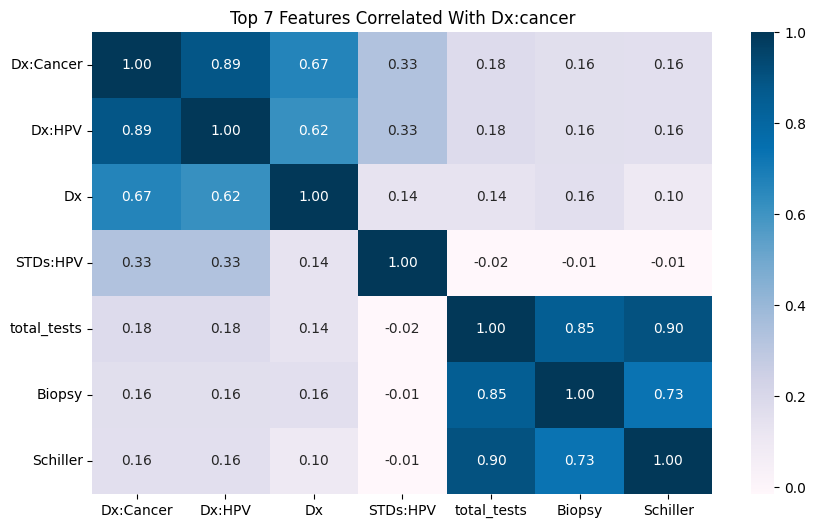

In [71]:
n = 7
target = "Dx:Cancer"

# 상관 관계 행렬 계산
corr = risk_factor_df.select_dtypes(include=[np.number]).corr()

# "Dx:Cancer" 열과의 상관 관계를 내림차순으로 정렬하고 상위 n개를 선택
top_corr_features = corr.nlargest(n + 1, target)[0:7].index

# 선택된 변수들 간의 상관 관계 행렬 계산
selected_corr_matrix = risk_factor_df[top_corr_features].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(selected_corr_matrix, annot=True, cmap='PuBu', fmt=".2f")
plt.title(f"Top {n} Features Correlated With {target.capitalize()}")
plt.show()

#HPV 진단과 자궁경부암 진단은 약 +0.89의 상관관계가 있음을 알 수 있는데, 이는 강한 양의 상관관계를 나타내고 있음을 알 수 있습니다. 어떤 면에서는 HPV 진단이 자궁경부암 진단으로 이어질 가능성이 높다고 해석할 수 있습니다.

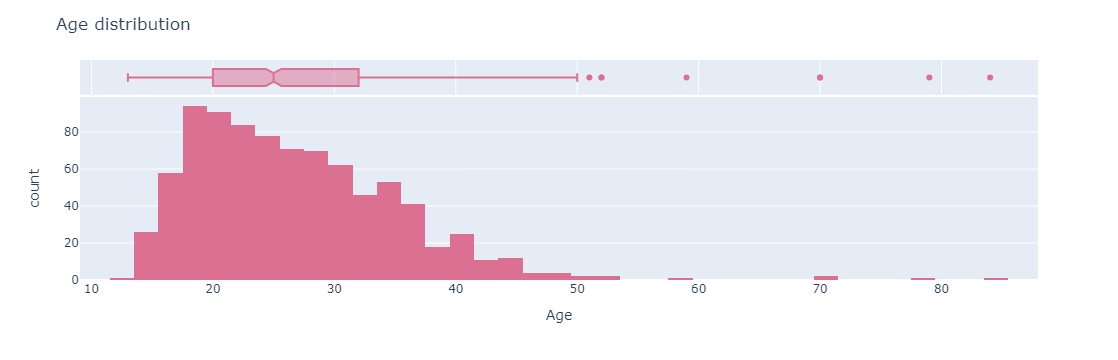

In [73]:
#mayo clinic에서 주장하는 말
#성적 파트너의 수가 많을수록 HPV에 걸릴 가능성이 커집니다.
#초기 성행위. 어린 나이에 성관계를 가지면 HPV에 걸릴 위험이 높아집니다.
#면역력이 약해지는 것. 다른 건강 상태로 인해 면역력이 약해지고 HPV에 걸리면 자궁경부암에 걸릴 확률이 더 높습니다.

#그냥 데이터 상 나이에 따른 분포
age_dist = px.histogram(risk_factor_df, x="Age", marginal="box", color_discrete_sequence=["palevioletred"])
age_dist.update_layout(title="Age distribution")
age_dist.show()

                           Dx:Cancer    Dx:HPV  Number of sexual partners
Dx:Cancer                   1.000000  0.886508                   0.023699
Dx:HPV                      0.886508  1.000000                   0.028646
Number of sexual partners   0.023699  0.028646                   1.000000


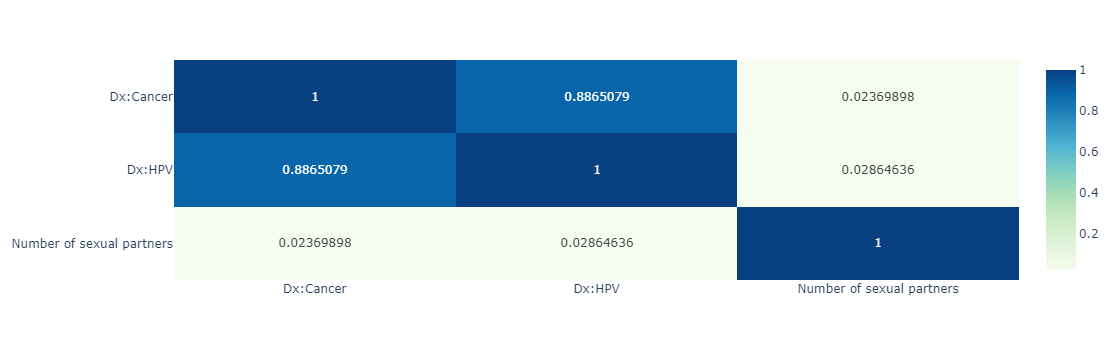

In [74]:
diagnoses_num_partner_compare_cols = ['Dx:Cancer',
                                      'Dx:HPV',
                                      "Number of sexual partners",]
corr_matrix = risk_factor_df[diagnoses_num_partner_compare_cols].corr()
print(corr_matrix)
diagnoses_num_partner_heatmap = px.imshow(corr_matrix,
                              aspect="auto",
                              color_continuous_scale="gnbu",
                              text_auto=True)
diagnoses_num_partner_heatmap.show()

#초기 성행위. 어린 나이에 성관계를 가지면 HPV에 걸릴 위험이 높아진다는 mayo clinic에서의 주장은 이 데이터에선 입증할 수 없다(상관계수 0.02864..)

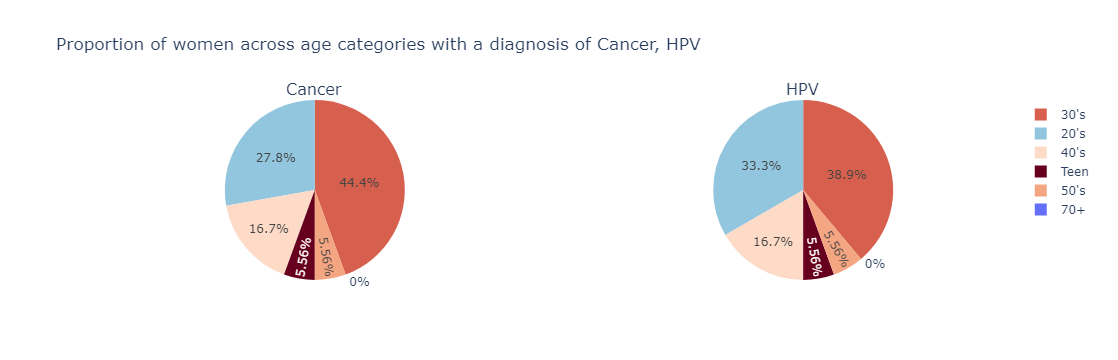

In [75]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles=["Cancer", "HPV"])
fig.add_trace(go.Pie(labels=risk_factor_df["age_cat"],
                     values=risk_factor_df["Dx:Cancer"],
                     name="Cancer", marker_colors=px.colors.sequential.RdBu),
              1, 1)
fig.add_trace(go.Pie(labels=risk_factor_df["age_cat"],
                     values=risk_factor_df["Dx:HPV"],
                     name="HPV", marker_colors=px.colors.sequential.RdBu),
              1, 2)

fig.update_traces(hole=.0, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Proportion of women across age categories with a diagnosis of Cancer, HPV",
)
fig.show()
#correlation이 서로 높은 만큼 실제로 각 병에 나이분포도 비슷한 것을 알 수 있다.(즉, 나이 관계없이 Correlation이 높다)

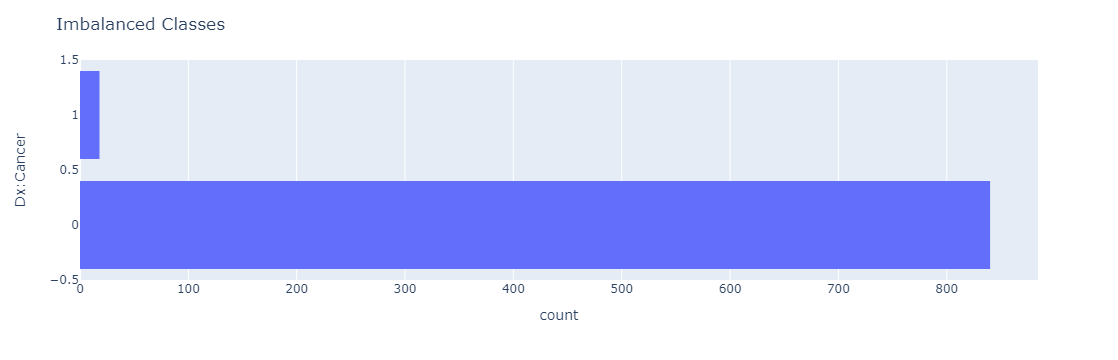

In [76]:
dx_cancer = px.histogram(risk_factor_df, y="Dx:Cancer")
dx_cancer.update_layout(bargap=0.2)
dx_cancer.update_layout(title = "Imbalanced Classes")
dx_cancer.show()

In [78]:
X = risk_factor_df.drop(["Dx:Cancer", "age_cat"], axis=1)
y = risk_factor_df["Dx:Cancer"].copy()
null_df = risk_factor_df.isnull().sum() 

In [79]:
adasyn = ADASYN(random_state=42)
x_adasyn,y_adasyn = adasyn.fit_resample(X,y)
risk_factor_df = x_adasyn.join(y_adasyn)

In [80]:
risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

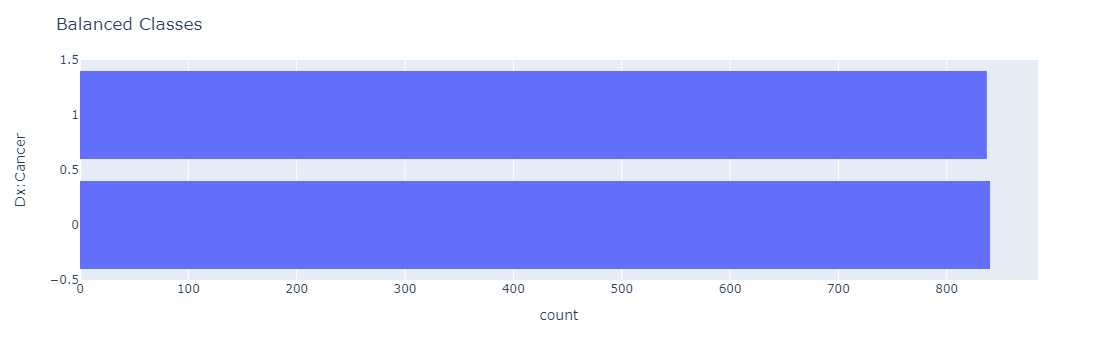

In [81]:
dx_cancer = px.histogram(risk_factor_df, y="Dx:Cancer")
dx_cancer.update_layout(bargap=0.2)
dx_cancer.update_layout(title = "Balanced Classes")
dx_cancer.show()

In [82]:
train_set = None
test_set = None 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(risk_factor_df, risk_factor_df["age_cat"]):
    train_set = risk_factor_df.loc[train_idx]
    test_set = risk_factor_df.loc[test_idx]
cols_to_drop = ["age_cat","total_std","total_tests"]
for set_ in (train_set, test_set):
    for col in cols_to_drop:
        set_.drop(col, axis=1, inplace=True)

In [83]:
X_train = train_set.drop("Dx:Cancer", axis=1)
y_train = train_set["Dx:Cancer"].copy()

X_test = test_set.drop("Dx:Cancer", axis=1)
y_test = test_set["Dx:Cancer"].copy()

# PCA component 항목들
We see that 13 out of 35 components explain 99% of the variance of the data. This is means, we can discard the other 23 components, this will signifcantly increase performance. due to a 65% reduction in features.

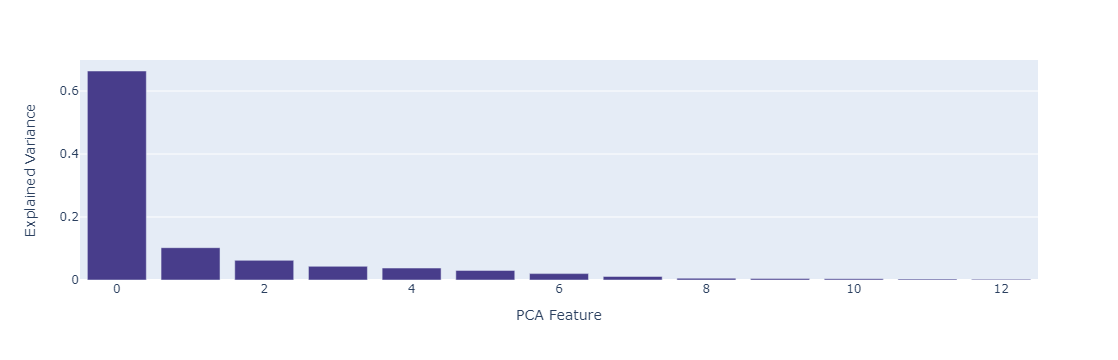

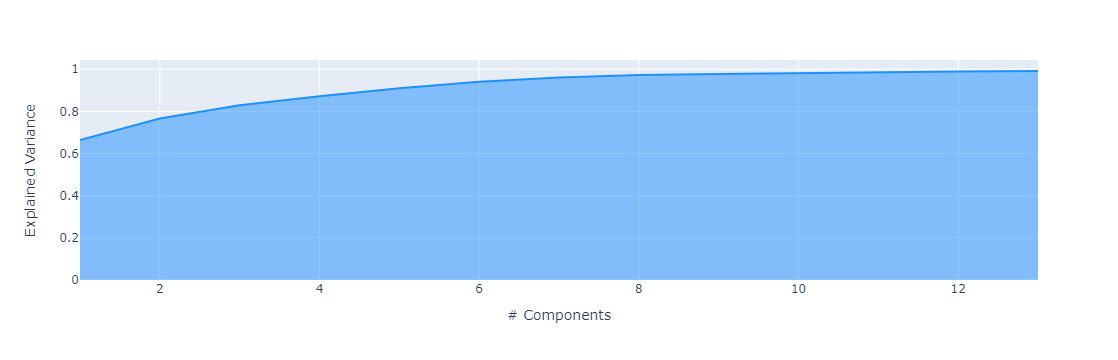

In [84]:
XT = RobustScaler().fit_transform(X_train)
pca = PCA(n_components=0.99)
XT = pca.fit_transform(XT)

dimensions = px.bar(x=range(pca.n_components_), y=pca.explained_variance_ratio_,
                    color_discrete_sequence=["darkslateblue"],
                    labels={"x":"PCA Feature","y":"Explained Variance"})
dimensions.show()
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

explained_variance = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
    color_discrete_sequence=["dodgerblue"]
)
explained_variance.show()

In [85]:
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=13))
])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# PCA 이후
PCA 이후 data로 LogisticRegression,KNeighborsClassifier, SVC 진행

In [86]:
param_grid = {'C': np.logspace(-5, 8, 15)}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=10,refit=True).fit(X_train,y_train)
logreg_cv = LogisticRegression(**logreg_cv.best_params_)

In [87]:
knn_clf = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": list(np.arange(1, 100, 2))}
knn_clf_cv = GridSearchCV(knn_clf, knn_param_grid, cv=10,refit=True).fit(X_train,y_train)
knn_clf_cv = KNeighborsClassifier(**knn_clf_cv.best_params_)

In [88]:
svm_clf = SVC()
svc_param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), }
svm_clf_cv = GridSearchCV(svm_clf, svc_param_grid, cv=5)

In [89]:
col_names = ["Classifier Name", "Accuracy Score", "Precision Score",
             "Recall Score", "F1 Score"]
summary_df = pd.DataFrame(columns=col_names)

est_name = []
est_acc = []
precision_score = []
recall_score = []
f1score = []
est_conf_matrix = []

estimators = [
    ("LogisticRegression", logreg_cv),
    ("KNeighborsClassifier", knn_clf_cv),
    ("SupportVectorClassifier", svm_clf_cv)]

for i in range(0, len(estimators)):
    clf_name = estimators[i][0]
    clf = estimators[i][1]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print(pd.crosstab(y_test,y_pred,rownames=["Actual"],colnames=["predicted"],margins=True))
    est_name.append(estimators[i][0])
    est_acc.append(accuracy_score(y_test, y_pred))
    scores = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    precision_score.append(scores[0])
    recall_score.append(scores[1])
    f1score.append(scores[2])
    est_conf_matrix.append(confusion_matrix(y_test,y_pred))


summary_df[col_names[0]] = est_name
summary_df[col_names[1]] = est_acc
summary_df[col_names[2]] = precision_score
summary_df[col_names[3]] = recall_score
summary_df[col_names[4]] = f1score

# 각 모델당 TP,TN,FP,FN 지표

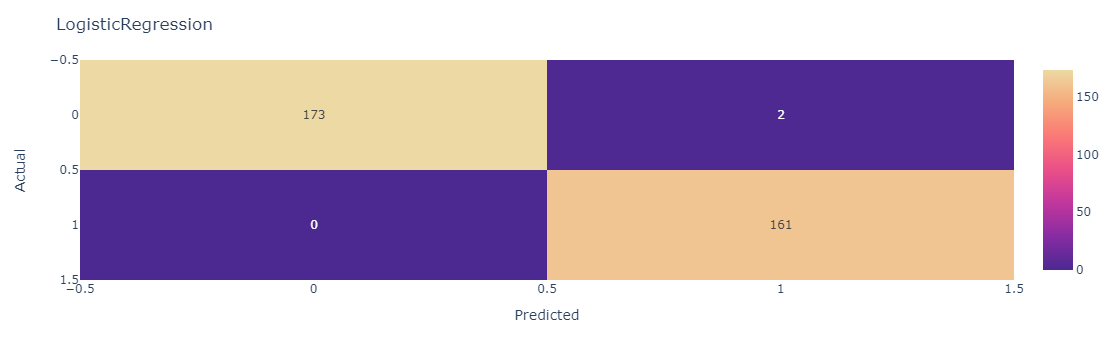

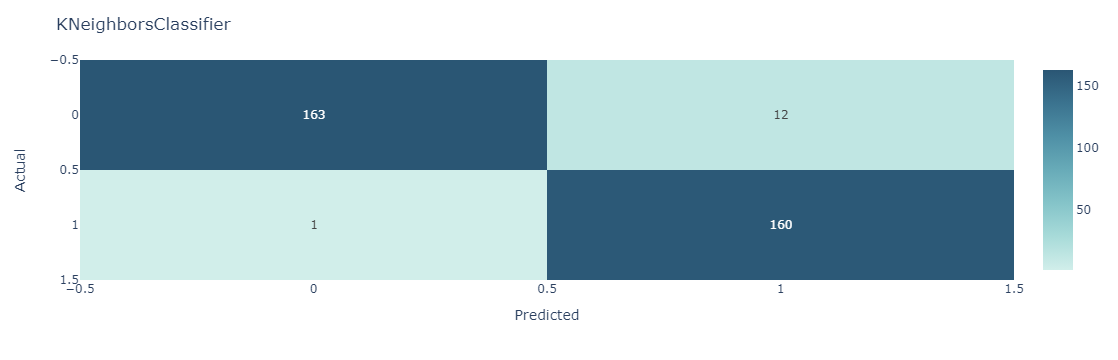

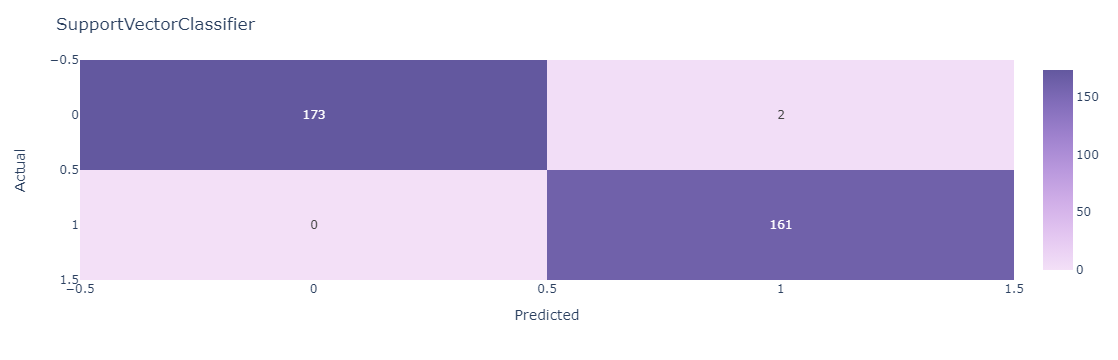

In [90]:
color_scales = ["agsunset","teal","purp","viridis"]
for i in range(0,len(est_conf_matrix)):
    heatmap = px.imshow(est_conf_matrix[i],aspect="auto",
                        text_auto=True,
                        color_continuous_scale=color_scales[i])
    heatmap.update_layout(title = est_name[i])
    heatmap.update_xaxes(title="Predicted")
    heatmap.update_yaxes(title="Actual")
    heatmap.show()

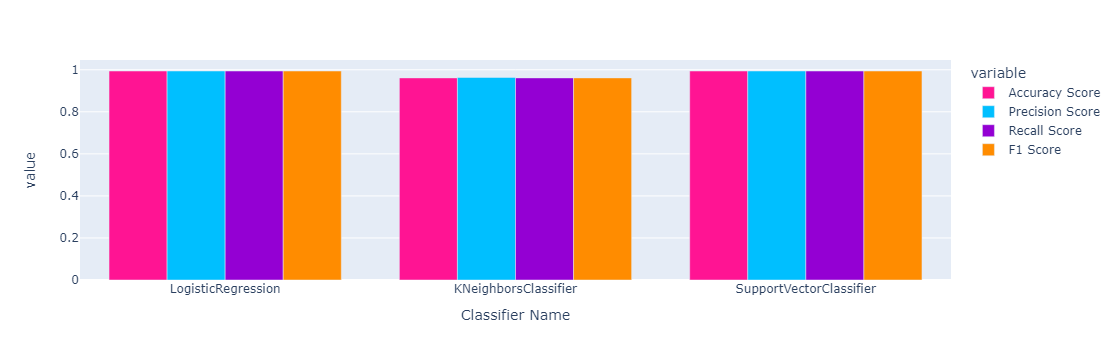

In [91]:
acc_comparison = px.bar(summary_df, x="Classifier Name",
                        y=col_names[1:len(col_names)],
                        color_discrete_sequence=["deeppink",
                                                 "deepskyblue",
                                                 "darkviolet",
                                                 "darkorange"],
                        barmode="group")
acc_comparison.show()
